In [3]:
!kaggle datasets download manasvi12/skin-cancer-isic-2020-segmented-both

Dataset URL: https://www.kaggle.com/datasets/manasvi12/skin-cancer-isic-2020-segmented-both
License(s): unknown




  0%|          | 0.00/816M [00:00<?, ?B/s]
  0%|          | 1.00M/816M [00:02<36:03, 395kB/s]
  0%|          | 2.00M/816M [00:04<26:15, 542kB/s]
  0%|          | 3.00M/816M [00:05<21:14, 669kB/s]
  0%|          | 4.00M/816M [00:06<17:51, 794kB/s]
  1%|          | 5.00M/816M [00:06<15:19, 925kB/s]
  1%|          | 6.00M/816M [00:07<13:50, 1.02MB/s]
  1%|          | 7.00M/816M [00:08<13:02, 1.08MB/s]
  1%|          | 8.00M/816M [00:10<16:42, 845kB/s] 
  1%|          | 9.00M/816M [00:12<18:46, 751kB/s]
  1%|          | 10.0M/816M [00:12<15:28, 910kB/s]
  1%|▏         | 11.0M/816M [00:13<13:16, 1.06MB/s]
  1%|▏         | 12.0M/816M [00:13<11:18, 1.24MB/s]
  2%|▏         | 13.0M/816M [00:14<10:22, 1.35MB/s]
  2%|▏         | 14.0M/816M [00:15<09:17, 1.51MB/s]
  2%|▏         | 15.0M/816M [00:15<08:50, 1.58MB/s]
  2%|▏         | 16.0M/816M [00:16<08:04, 1.73MB/s]
  2%|▏         | 17.0M/816M [00:16<08:05, 1.72MB/s]
  2%|▏         | 18.0M/816M [00:17<08:12, 1.70MB/s]
  2%|▏         | 19.0M/816M

In [10]:
import zipfile
zip_ref = zipfile.ZipFile(r'c:\Users\Nandani singh\Downloads\CVDL INTENSHIP\skin-cancer-isic-2020-segmented-both.zip', 'r')
zip_ref.extractall('C:')
zip_ref.close()

In [20]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2




ModuleNotFoundError: No module named 'distutils'

In [ ]:
from PIL import Image
import cv2

# Paths to train and test directories
TRAIN_ORIGINAL_DIR = '/content/original images/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
TRAIN_SEGMENTED_DIR = '/content/segmented images/segmented/Train'
TEST_ORIGINAL_DIR = '/content/original images/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
TEST_SEGMENTED_DIR = '/content/segmented images/segmented/Test'

IMG_SIZE = (224, 224)  # Resize images to 224x224
CLASS_NAMES = sorted(os.listdir(TRAIN_ORIGINAL_DIR))  # Get class names from folder structure
NUM_CLASSES = len(CLASS_NAMES)

# Mapping class names to numeric labels
class_to_label = {class_name: idx for idx, class_name in enumerate(CLASS_NAMES)}
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()}



In [ ]:
import os
import cv2
import numpy as np

def load_combined_images(original_dir, segmented_dir, img_size=(224, 224)):
    images = []
    labels = []
    for class_name in os.listdir(original_dir):
        orig_class_path = os.path.join(original_dir, class_name)
        seg_class_path = os.path.join(segmented_dir, class_name)

        label = class_to_label[class_name]

        for img_name in os.listdir(orig_class_path):
            try:
                # Handle different formats for original and segmented images
                orig_img_path = os.path.join(orig_class_path, img_name)

                # Check for corresponding segmented image (e.g., with .tiff extension)
                base_name = os.path.splitext(img_name)[0]  # Remove extension
                seg_img_path = os.path.join(seg_class_path, f"{base_name}.tiff")

                # Load and resize original image
                orig_img = cv2.imread(orig_img_path)
                if orig_img is None:
                    raise FileNotFoundError(f"Original image not found: {orig_img_path}")
                orig_img = cv2.resize(orig_img, img_size)
                orig_img = orig_img / 255.0

                # Load and resize segmented image
                seg_img = cv2.imread(seg_img_path, cv2.IMREAD_GRAYSCALE)
                if seg_img is None:
                    raise FileNotFoundError(f"Segmented image not found: {seg_img_path}")
                seg_img = cv2.resize(seg_img, img_size)
                seg_img = seg_img / 255.0
                seg_img = np.expand_dims(seg_img, axis=-1)  # Add channel dimension

                # Combine original and segmented images
                combined_img = np.concatenate((orig_img, seg_img), axis=-1)

                images.append(combined_img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    return np.array(images), np.array(labels)


In [ ]:
# Load training and testing data
X_train, y_train = load_combined_images(TRAIN_ORIGINAL_DIR, TRAIN_SEGMENTED_DIR)
X_test, y_test = load_combined_images(TEST_ORIGINAL_DIR, TEST_SEGMENTED_DIR)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2]
)
datagen.fit(X_train)



In [ ]:
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 4)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    # Fully Connected Layers
    Flatten(),
    Dense(units=128, activation='relu', kernel_regularizer=l2(0.0010)),
    Dropout(0.3),  # Dropout for regularization
    Dense(units=64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),  # Dropout for regularization
    Dense(NUM_CLASSES, activation='softmax')  # Output Layer for multi-class classification
])
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,178,985 (42.64 MB)

 Trainable params: 11,178,537 (42.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from re import X
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr]
)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.3366 - loss: 9.4485 - val_accuracy: 0.0848 - val_loss: 4.1466 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4624 - loss: 5.5983 - val_accuracy: 0.2522 - val_loss: 3.5018 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5034 - loss: 4.1440 - val_accuracy: 0.0781 - val_loss: 6.2369 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5604 - loss: 3.6334 - val_accuracy: 0.1161 - val_loss: 6.3280 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5677 - loss: 3.7442
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5677 - loss: 3.7439 - val_accuracy: 0.3661 - val_loss: 3.5964 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6183 - loss: 3.1872 - 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Traning Accuracy: {accuracy * 100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9995 - loss: 0.9236
Traning Accuracy: 99.83%


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 0.6201 - loss: 5.8879
Test Accuracy: 57.63%


In [ ]:
# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(y_test_labels, y_pred, target_names=CLASS_NAMES))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.56      0.56      0.56        16
      basal cell carcinoma       0.82      0.88      0.85        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.43      0.19      0.26        16
                     nevus       0.39      0.88      0.54        16
pigmented benign keratosis       0.67      0.88      0.76        16
      seborrheic keratosis       0.50      0.67      0.57         3
   squamous cell carcinoma       0.69      0.56      0.62        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.58       118
                 macro avg       0.53      0.62      0.56       118
              weighted avg       0.51      0.58      0.52       118



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Assuming y_test is one-hot encoded
y_pred = model.predict(X_test)  # Get model predictions
y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class indices
y_true_classes = y_test.argmax(axis=1)  # Convert true labels to class indices


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the metrics as percentages
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


Accuracy: 55.93%
Precision: 53.48%
Recall: 55.93%
F1 Score: 51.37%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 9  0  0  1  2  1  2  0  1]
 [ 1 14  0  0  0  1  0  0  0]
 [ 5  2  0  0  6  0  0  3  0]
 [ 0  0  0  3  8  5  0  0  0]
 [ 0  0  0  1 14  0  0  1  0]
 [ 0  0  0  1  1 14  0  0  0]
 [ 0  0  0  1  0  0  2  0  0]
 [ 1  1  0  0  5  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  3]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


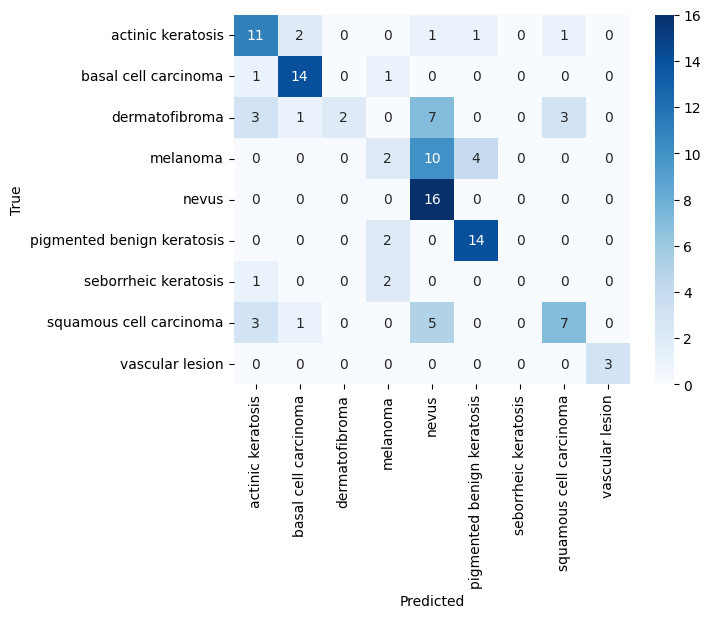

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'classes' is defined elsewhere in your code
# ...

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (multilabel-indicator format)
# Assuming a threshold of 0.5 for assigning classes
threshold = 0.5
y_pred_multilabel = (y_pred_probs > threshold).astype(int)

# If y_test is also in multilabel-indicator format:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_multilabel.argmax(axis=1))  # Compare argmax for both

# OR, if y_test is in multiclass format:
# cm = confusion_matrix(y_test, y_pred_multilabel.argmax(axis=1))  # Compare multiclass with argmax of multilabel

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

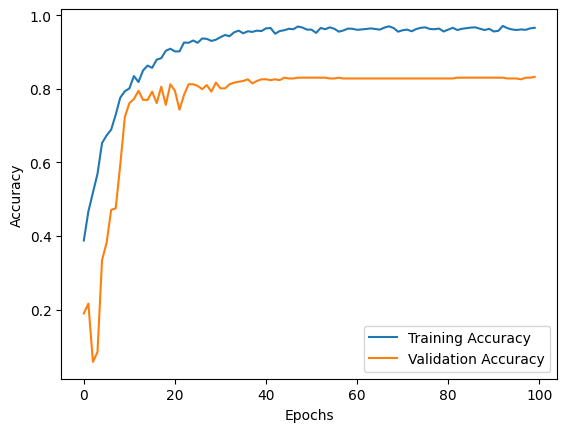

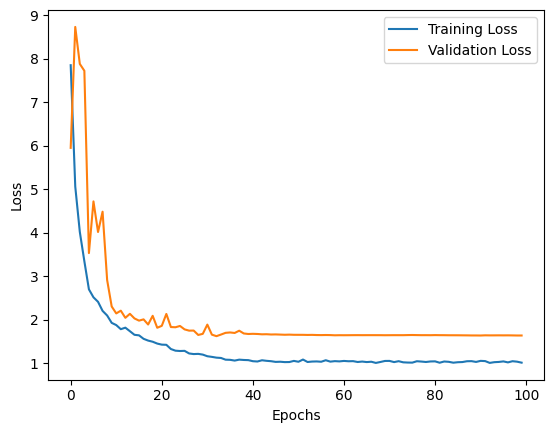

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
